# Read file

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [10]:
%pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
   ------ --------------------------------- 1.8/11.5 MB 10.1 MB/s eta 0:00:01
   ---------------- ----------------------- 4.7/11.5 MB 11.9 MB/s eta 0:00:01
   --------------------------- ------------ 7.9/11.5 MB 13.2 MB/s eta 0:00:01
   ---------------------------------------  11.3/11.5 MB 13.8 MB/s eta 0:00:01
   ---------------------------------------- 11.5/11.5 MB 13.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path().cwd().parent
sys.path.append(str(PROJECT_ROOT))

import torch.nn.functional as F
from src.utils import *
from src.datatype import *
from src.renderer import *

image_path = PROJECT_ROOT / 'ReMIND2Reg_dataset' / 'imagesTr'

c:\Users\noe\anaconda3\envs\torchIO\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
UR = UltrasoundRenderer(100, 0.1)

In [32]:
patient_id = "003" # between 000 and 102, t1 and t2 don't exist for all patients
iUS_file = f"ReMIND2Reg_0{patient_id}_0000.nii.gz"
t1_file = f"ReMIND2Reg_0{patient_id}_0001.nii.gz"
t2_file = f"ReMIND2Reg_0{patient_id}_0002.nii.gz"

dataset = MRIDataset([image_path / t1_file], "T1", axis=0)
volume = dataset[0]["image"].squeeze(0)

tensor([1400509.3750, 1400382.0000, 1400382.0000, 1400382.0000, 1400382.0000,
        1400382.0000, 1400509.3750, 1400509.3750, 1400636.6250, 1400764.0000,
        1400891.3750, 1400891.3750, 1400764.0000, 1400764.0000, 1400636.6250,
        1400636.6250, 1400509.3750, 1400382.0000, 1400382.0000, 1400382.0000,
        1400382.0000, 1400636.6250, 1401018.6250, 1401528.0000, 1402037.3750,
        1402037.3750, 1401400.6250, 1404711.3750, 1414388.6250, 1428395.6250,
        1448896.3750, 1464303.8750, 1471944.0000, 1475636.6250, 1473344.6250,
        1474490.6250, 1480857.3750, 1486460.1250, 1491298.6250, 1494100.1250,
        1493590.8750, 1491808.1250, 1487860.8750, 1477928.7500, 1458064.6250,
        1437945.6250, 1417445.0000, 1405093.3750, 1406112.0000, 1410696.1250,
        1421137.5000, 1430432.8750, 1437691.0000, 1442784.3750, 1444312.3750,
        1446604.3750, 1450042.5000, 1449915.1250, 1443930.3750, 1434762.2500,
        1420119.0000, 1412096.7500, 1415025.5000, 1420246.1250, 

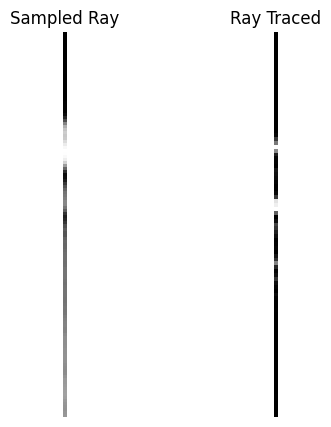

In [118]:
# sample volume 
sample_ray = volume[128,128,0:128].unsqueeze(0)

ray_one = UR.simulate_ray(
    volume,
    torch.tensor([128.,128.,0.]),
    torch.tensor([0.,0.,1.]),
    
).unsqueeze(0)

fig, ax = plt.subplots(1, 2, figsize=(5, 5))

ax[0].imshow(sample_ray.cpu().numpy().T, cmap="gray")
ax[0].set_title("Sampled Ray")
ax[0].axis("off")

ax[1].imshow(ray_one.cpu().numpy().T, cmap="gray")
ax[1].set_title("Ray Traced")
ax[1].axis("off")
plt.show()

In [86]:
from tqdm import tqdm

In [119]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def plot_fan(
    angle: int = 45,
    rays: int = 128,
    source: np.ndarray = np.array([128., 128., 0.]),
    ax: plt.Axes = None,
):
    """
    Plots a simulated ultrasound fan frame.
    
    Args:
        angle: Total angular spread of the fan (degrees)
        rays: Number of rays in the fan
        source: Source position (numpy array of shape (3,))
        ax: Matplotlib axis to plot on (optional)
    """
    # 1. Create ray directions (vectorized)
    thetas = np.radians(np.linspace(-angle, angle, rays))  # shape (rays,)
    directions = np.stack([
        np.sin(thetas),            # x
        np.zeros_like(thetas),     # y
        np.cos(thetas)             # z
    ], axis=-1)                   # shape (rays, 3)

    # 2. Simulate frame
    sim_framed = UR.simulate_frame(
        volume=volume,
        source=torch.tensor(source, dtype=torch.float32),
        directions=torch.tensor(directions, dtype=torch.float32),
    )

    # 3. Convert to numpy
    frame_np = sim_framed.detach().cpu().numpy()  # shape (rays, samples)
    n_rays, n_samples = frame_np.shape

    # 4. Compute points for each ray and distance (vectorized)
    ray_indices = np.arange(n_samples)  # (samples,)
    directions_xz = np.stack([
        np.sin(thetas), 
        np.cos(thetas)
    ], axis=1)  # shape (rays, 2) for (x, z) directions only

    # Expand to (rays, samples, 2)
    directions_xz = directions_xz[:, None, :]    # (rays, 1, 2)
    ray_indices = ray_indices[None, :, None]     # (1, samples, 1)

    points = source[[0, 2]][None, None, :] + ray_indices * directions_xz  # (rays, samples, 2)

    x_coords = points[..., 0].flatten()
    z_coords = points[..., 1].flatten()
    intensities = frame_np.flatten()

    # 5. Plot
    if ax is None:
        print("No axis provided, creating a new one.")
        fig, ax = plt.subplots(figsize=(6, 6))
    
    ax.scatter(x_coords, z_coords, c=intensities, cmap='gray', s=1)
    ax.set_facecolor('black')
    ax.set_title("Fan-shaped Ultrasound Frame")
    ax.set_aspect('equal')

    return ax


C:\Users\noe\AppData\Local\Temp\ipykernel_73584\1363108112.py:31: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



tensor([1400764.0000, 1400827.7500, 1400891.3750, 1400891.5000, 1400891.3750,
        1400723.2500, 1400667.5000, 1400757.5000, 1400680.3750, 1400544.0000,
        1400382.1250, 1400382.0000, 1400350.2500, 1400431.0000, 1400610.8750,
        1400821.5000, 1400851.5000, 1400764.0000, 1400764.0000, 1400708.6250,
        1400603.0000, 1400512.2500, 1400682.3750, 1400822.2500, 1400891.1250,
        1400832.7500, 1400715.1250, 1400668.5000, 1400698.0000, 1400507.0000,
        1402057.6250, 1409363.0000, 1419204.0000, 1431261.6250, 1444267.0000,
        1455729.5000, 1460768.7500, 1463110.0000, 1465982.3750, 1470004.7500,
        1474151.5000, 1478513.7500, 1480354.0000, 1480370.1250, 1478145.8750,
        1469821.8750, 1458863.0000, 1446062.7500, 1432746.0000, 1421665.1250,
        1413378.1250, 1408968.8750, 1406310.8750, 1408019.1250, 1410625.2500,
        1412883.0000, 1416440.0000, 1421098.7500, 1426255.5000, 1426444.6250,
        1423873.5000, 1418846.7500, 1416018.2500, 1418016.8750, 

C:\Users\noe\AppData\Local\Temp\ipykernel_73584\1363108112.py:50: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)



tensor([1400764.0000, 1400672.0000, 1400580.2500, 1400548.2500, 1400731.0000,
        1400787.0000, 1400734.7500, 1400629.8750, 1400538.0000, 1400572.5000,
        1400638.8750, 1400636.6250, 1400597.8750, 1400509.7500, 1400513.6250,
        1400606.2500, 1400764.0000, 1400755.8750, 1400705.5000, 1400727.7500,
        1400755.2500, 1400899.6250, 1401047.3750, 1401065.0000, 1401121.3750,
        1401339.0000, 1401985.2500, 1402759.8750, 1404001.2500, 1406687.2500,
        1412716.3750, 1423394.1250, 1436991.3750, 1448863.0000, 1455583.0000,
        1459458.3750, 1462273.3750, 1465786.0000, 1472180.1250, 1480754.5000,
        1483947.8750, 1484837.8750, 1482475.2500, 1474504.2500, 1462547.2500,
        1446134.1250, 1429095.8750, 1415643.0000, 1408592.2500, 1405335.5000,
        1406082.5000, 1412090.0000, 1419518.6250, 1426620.1250, 1430643.5000,
        1433782.2500, 1437144.8750, 1440190.8750, 1442251.5000, 1442210.5000,
        1440155.3750, 1435642.7500, 1427141.5000, 1421657.8750, 

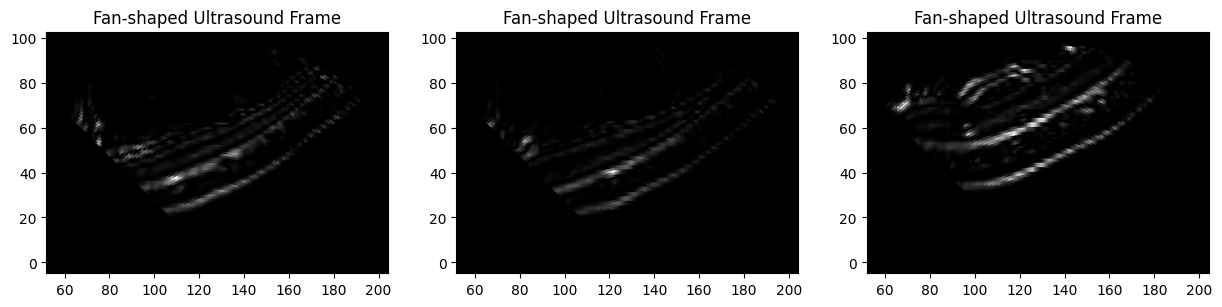

In [120]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
plot_fan(angle=45, rays=150, source=torch.tensor([128., 90.,0.]), ax=ax[0])
plot_fan(angle=45, rays=150, source=torch.tensor([128., 110.,0.]), ax=ax[1])
plot_fan(angle=45, rays=150, source=torch.tensor([128., 200.,0.]), ax=ax[2])
plt.show()

9it [05:07, 34.16s/it]


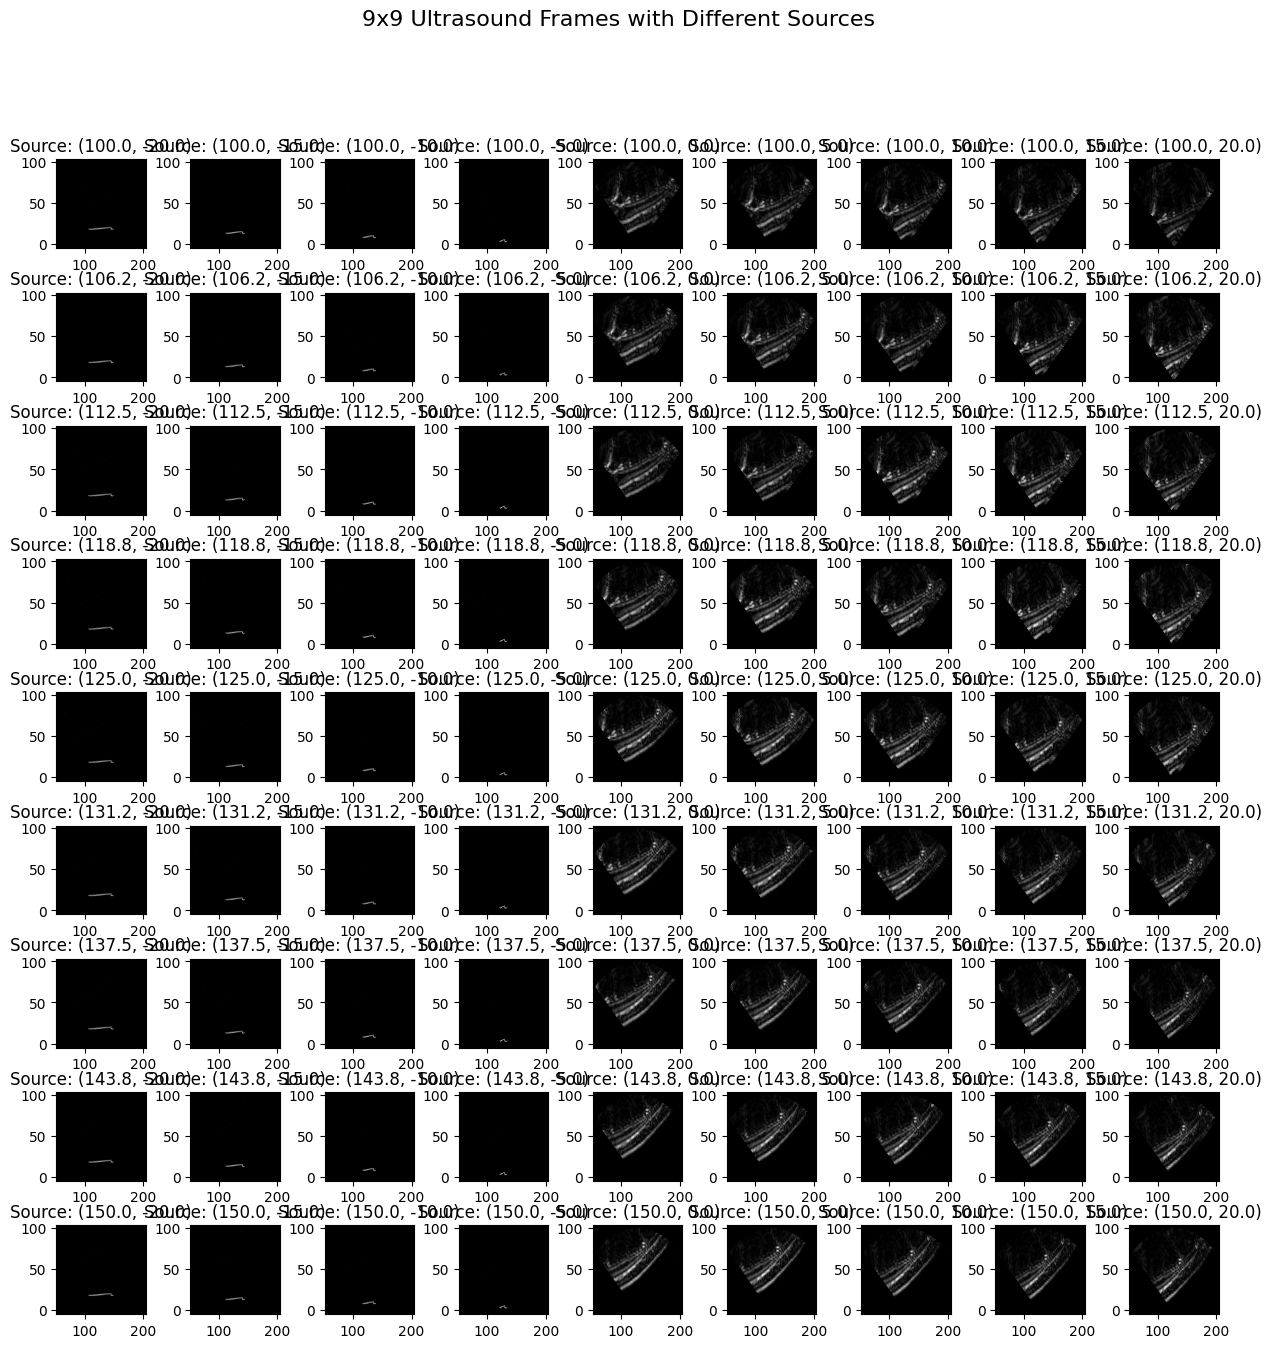

In [87]:
angle = 45  # degrees
rays = 128

# Define a grid of sources for the 9x9 plot
grid_size = 9
x_positions = np.linspace(100, 150, grid_size)
z_positions = np.linspace(-20, 20, grid_size)

fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i, x in tqdm(enumerate(x_positions)):
    for j, z in enumerate(z_positions):
        source = torch.tensor([x, 128., z], dtype=torch.float32)
        ax = axes[i, j]
        
        plot_fan(angle=angle, rays=rays, source=source, ax=ax)
        ax.set_title(f"Source: ({x:.1f}, {z:.1f})")

plt.suptitle("9x9 Ultrasound Frames with Different Sources", fontsize=16)
plt.show()

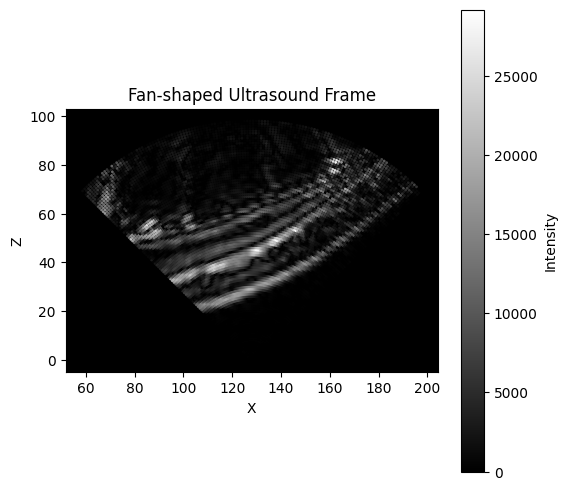

In [79]:
angle = 45  # degrees
rays = 128

thetas = np.radians(np.linspace(-angle,angle, rays))  # 64 rays across the fan
directions = [np.array([np.sin(theta), 0, np.cos(theta)]) for theta in thetas]

sim_framed = UR.simulate_frame(
    volume=volume,
    source=torch.tensor([128.,128.,0.]),
    directions=torch.tensor(directions, dtype=torch.float32),
)

frame_np = sim_framed.detach().cpu().numpy()
n_rays, n_samples = frame_np.shape
source = np.array([128, 0])  # (x, z) — assuming 2D for display

# Scale ray length to match sample count
ray_len = n_samples
thetas = np.radians(np.linspace(-angle, angle, n_rays))

x_coords = []
z_coords = []
intensities = []

for i, theta in enumerate(thetas):
    for r in range(n_samples):
        direction = np.array([np.sin(theta), np.cos(theta)])
        point = source + r * direction
        x_coords.append(point[0])
        z_coords.append(point[1])
        intensities.append(frame_np[i, r])

# Create scatter plot with intensity
plt.figure(figsize=(6, 6))
plt.rcParams['axes.facecolor'] = 'black'

plt.scatter(x_coords, z_coords, c=intensities, cmap='gray', s=1)
plt.gca().set_aspect('equal')
plt.xlabel("X")
plt.ylabel("Z")
plt.title("Fan-shaped Ultrasound Frame")
plt.colorbar(label="Intensity")
plt.show()


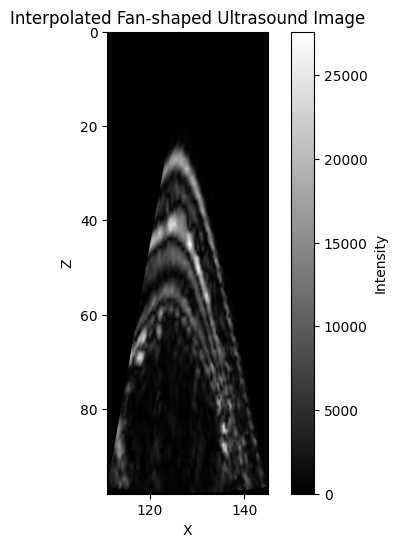

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Assuming sim_framed has shape (num_rays, num_samples)
frame_np = sim_framed.detach().cpu().numpy()
n_rays, n_samples = frame_np.shape

# Define source and angle range
source = np.array([128, 0])  # (x, z)
thetas = np.radians(np.linspace(-10, 10, n_rays))
ray_len = n_samples

# Convert polar coordinates (r, theta) → (x, z)
x_coords = []
z_coords = []
intensities = []

for i, theta in enumerate(thetas):
    for r in range(n_samples):
        direction = np.array([np.sin(theta), np.cos(theta)])
        point = source + r * direction
        x_coords.append(point[0])
        z_coords.append(point[1])
        intensities.append(frame_np[i, r])

x_coords = np.array(x_coords)
z_coords = np.array(z_coords)
intensities = np.array(intensities)

# Create a dense grid for interpolation
grid_x, grid_z = np.meshgrid(
    np.linspace(x_coords.min(), x_coords.max(), 512),
    np.linspace(z_coords.min(), z_coords.max(), 512)
)

# Interpolate intensity onto the grid
grid_intensity = griddata(
    points=(x_coords, z_coords),
    values=intensities,
    xi=(grid_x, grid_z),
    method='linear',
    fill_value=0.0
)

# Plot the interpolated fan image
plt.figure(figsize=(6, 6))
plt.imshow(
    grid_intensity,
    extent=(x_coords.min(), x_coords.max(), z_coords.max(), z_coords.min()),  # flip z to look like real US
    cmap='gray',
    aspect='equal'
)
plt.xlabel("X")
plt.ylabel("Z")
plt.title("Interpolated Fan-shaped Ultrasound Image")
plt.colorbar(label="Intensity")
plt.show()
